In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import glob
import sys
sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.metrics import calculate_mcc

In [2]:
def categorize_files(outputfolder_path_list):
    """
    Categorize files in the output folders into metrics report files, metadata files, and log files.

    Args:
        outputfolder_path_list (list): List of output folder paths.

    Returns:
        dict: A dictionary containing categorized files.
    """
    file_list = []
    for outputfolder_path in outputfolder_path_list:
        file_list.extend(glob.glob(os.path.join(outputfolder_path, "*")))

    categorized_files = {
        "metrics_report_files": [f for f in file_list if "metrics_report" in f],
        "metadata_files": [f for f in file_list if "metadata" in f],
        "log_files": [f for f in file_list if "log" in f],
        "prediction_files": [f for f in file_list if "predictions" in f],
    }

    print("Metrics Report Files:")
    for file in categorized_files["metrics_report_files"]:
        print(file)
    print("\nMetadata Files:")
    for file in categorized_files["metadata_files"]:
        print(file)
    print("\nLog Files:")
    for file in categorized_files["log_files"]:
        print(file)
    print("\nPrediction Files:")
    for file in categorized_files["prediction_files"]:
        print(file)

    return categorized_files
    

In [3]:
def get_predictions_by_model_task_dataset(df, model, task, dataset):
    """
    Filter predictions DataFrame by model, task, and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df['model'] == model) & (df['task'] == task) & (df['dataset'] == dataset)]

In [4]:
def get_predictions_by_task_dataset(df, task, dataset):
    """
    Filter predictions DataFrame by task and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df["task"] == task) & (df["dataset"] == dataset)]




In [5]:
def get_predictions_by_model(df, model):
    """
    Filter predictions DataFrame by model.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[df["model"] == model]




In [6]:
def get_predictions_by_dataset(df, dataset):
    """
    Filter predictions DataFrame by dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[df["dataset"] == dataset]

In [7]:
def plot_pred_label_distribution(model, task, dataset):
    """
    Plot the distribution of predictions and labels.

    Args:
        preds (array-like): Predictions from the model.
        labels (array-like): True labels.
        model (str): Model name.
        task (str): Task name.
        dataset (str): Dataset name.
    """
    single_df = get_predictions_by_model_task_dataset(
        all_predictions_df, 
        model=model, 
        task=task, 
        dataset=dataset
    )
    preds = single_df['predictions'].values
    labels = single_df['labels'].values
    plt.figure(figsize=(6, 4))
    plt.hist(preds, bins=30, alpha=0.5, label="Predictions", color="royalblue")
    plt.hist(labels, bins=60, alpha=0.5, label='Labels', color='orange')
    plt.title(f'Prediction and Label Distribution\nModel: {model}, Task: {task}, Dataset: {dataset}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.axvline(x=0.5, color="black", linestyle="dotted", label="Threshold (0.5)")
    plt.legend()
    plt.show()

In [10]:
outputfolder_path_list = [
    r"C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN",
]

In [11]:
cat_files = categorize_files(outputfolder_path_list)

Metrics Report Files:
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_metrics_report.json

Metadata Files:
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_aki_eicu_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_aki_hirid_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_aki_miiv_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_mortality_eicu_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_mortality_hirid_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_mortality_miiv_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_sepsis_eicu_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Repos/pulse/output/CNN\CNNModel_sepsis_hirid_20250603_135441_metadata.csv
C:/Users/janbe/Documents/GitHub Re

In [12]:
from sklearn.calibration import expit


all_predictions_df = pd.DataFrame()

# Regex pattern to extract model, task, dataset from filename
pattern = re.compile(r'([A-Za-z0-9]+)_([a-z]+)_([a-z]+)_predictions\.csv')

for file_path in cat_files['prediction_files']:
    df_temp = pd.read_csv(file_path)
    # Check if predictions are logits (e.g., outside [0, 1]) and convert to probabilities if needed
    if df_temp['predictions'].min() < 0 or df_temp['predictions'].max() > 1:
        df_temp['predictions'] = expit(df_temp['predictions'])  # convert logits to probabilities
    df_temp['binary_predictions'] = df_temp['predictions'].apply(lambda x: 1 if x >= 0.5 else 0)
    filename = os.path.basename(file_path)
    match = pattern.match(filename)
    if match:
        model, task, dataset = match.groups()
        df_temp['model'] = model
        df_temp['task'] = task
        df_temp['dataset'] = dataset
    else:
        df_temp['model'] = 'unknown'
        df_temp['task'] = 'unknown'
        df_temp['dataset'] = 'unknown'
    all_predictions_df = pd.concat([all_predictions_df, df_temp], ignore_index=True)

all_predictions_df.head(15)

,predictions,labels,binary_predictions,model,task,dataset
0,0.877499,0.0,1,unknown,unknown,unknown
1,0.843938,0.0,1,unknown,unknown,unknown
2,0.781067,0.0,1,unknown,unknown,unknown
3,0.735670,0.0,1,unknown,unknown,unknown
4,0.555286,0.0,1,unknown,unknown,unknown
5,0.678431,0.0,1,unknown,unknown,unknown
6,0.841827,0.0,1,unknown,unknown,unknown
7,0.717610,0.0,1,unknown,unknown,unknown
8,0.737283,0.0,1,unknown,unknown,unknown
9,0.790447,0.0,1,unknown,unknown,unknown


In [28]:
# Filter for a single model, task, and dataset combination
single_df = get_predictions_by_model_task_dataset(
    all_predictions_df, 
    model='RandomForest', 
    task='mortality', 
    dataset='miiv'  # Adjust dataset as needed
)

# Extract predictions and labels
preds = single_df['predictions'].values
labels = single_df['labels'].values

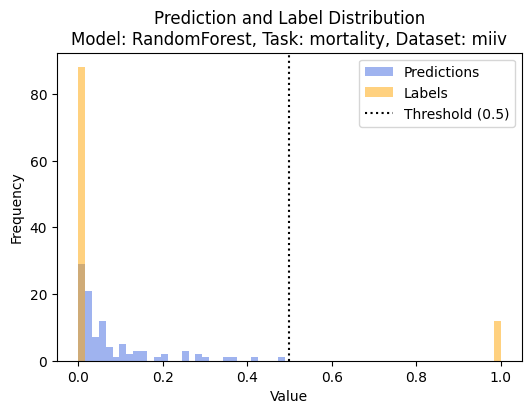

In [29]:
plot_pred_label_distribution('RandomForest', 'mortality', 'miiv')

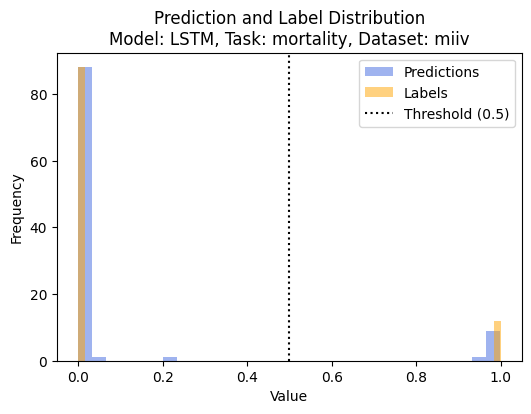

In [30]:
plot_pred_label_distribution('LSTM', 'mortality', 'miiv')

In [ ]:
from scipy.special import expit  # sigmoid function

binary_preds = (preds >= 0.5).astype(int)
binary_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Calculate MCC
mcc = calculate_mcc(binary_preds, labels)
print("MCC:", mcc)

MCC: 0.3663319999660611
